In [ ]:
from google.colab import drive
location = '/content/drive/'
drive.mount(location)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!pip install stable-baselines3[extra] torch torchvision gymnasium
!pip install drive/MyDrive/SMU\ MITB/Reinforcement\ Learning/oceanrl-0.1.0-py3-none-any.whl

Processing ./drive/MyDrive/SMU MITB/Reinforcement Learning/oceanrl-0.1.0-py3-none-any.whl
oceanrl is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


## Import modules

In [ ]:
import os, time, math, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Dict, Any, Tuple
import torch
import gymnasium as gym
from gymnasium import spaces
from gymnasium.wrappers import RescaleAction
from oceanrl import query as update_populations

# SB3 utilities (VecEnv, Monitor, PPO, callbacks, eval helper)
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnNoModelImprovement, BaseCallback, CallbackList
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import VecNormalize

## Initialise gymnasium environment

In [ ]:
@dataclass
class RewardConfig:
    K1: float = 0.001   # coefficient for salmon_caught
    K2: float = 0.01    # effort penalty
    K3: float = 100.0   # terminal log salmon bonus
    K4: float = 100.0   # terminal log shark bonus

horizon = 900  # 75 years * 12 months
seed = 2025

# cap for tanh-squash stability when effort is squashed in SB3 Gaussian policy
MAX_EFFORT = 20


# ---------- Gymnasium environment wrapper ----------
class OceanEnv(gym.Env):
    """
    Observation (5-dim):
        [log(1+salmon_t), log(1+shark_t), sin(2π*month/12), cos(2π*month/12), t/horizon]
    Action (1-dim):
        effort_t in [0, MAX_EFFORT]
    Reward:
        r_t = K1*salmon_caught_t - K2*effort_t, plus terminal K3*log(salmon_T+1) + K4*log(shark_T+1)
    Episode length: exactly 900 steps (months)
    """
    metadata = {"render_modes": []}

    def __init__(self, seed: int | None = None, reward_cfg: RewardConfig = RewardConfig()):
        super().__init__()
        self.reward_cfg = reward_cfg
        self.observation_space = spaces.Box(
            low=np.array([0.0, 0.0, 0.0], dtype=np.float32),
            high=np.array([np.inf, np.inf, 900], dtype=np.float32),
            dtype=np.float32
        )
        self.action_space = spaces.Box(low=0.0, high=MAX_EFFORT, shape=(1,), dtype=np.float32)
        self._rng = np.random.default_rng(seed)
        self.state = None
        self.t = 0
        self._episode_actions = []  # keep for plotting mean effort per episode
        self.salmon = None
        self.shark  = None
        self.month  = None
        self.total_salmon_caught = 0.0
        self.total_effort = 0.0


    def seed(self, seed: int | None = None):
        self._rng = np.random.default_rng(seed)

    def _encode_obs(self, salmon: float, shark: float, month: int) -> np.ndarray:
        s_log = math.log1p(max(salmon, 0.0))
        k_log = math.log1p(max(shark, 0.0))
        return np.array([s_log, k_log, month], dtype=np.float32)

    def reset(self, *, seed: int | None = None, options: Dict[str, Any] | None = None) -> Tuple[np.ndarray, Dict]:
        if seed is not None:
            self.seed(seed)
        salmon0 = 20000.0
        shark0  = 500.0
        month0  = 0
        self.state = (salmon0, shark0, month0)
        self.salmon, self.shark, self.month = self.state
        self.t = 0
        self._episode_actions = []
        self.total_salmon_caught = 0.0
        self.total_effort = 0.0
        return self._encode_obs(*self.state), {}

    def step(self, action: np.ndarray) -> Tuple[np.ndarray, float, bool, bool, Dict]:
        effort = float(np.clip(action[0], 0, MAX_EFFORT))
        salmon_t, shark_t, month_t = self.state

        #call function
        salmon_caught, salmon_next, shark_next = update_populations(salmon_t, shark_t, effort, month_t)

        r = self.reward_cfg.K1 * float(salmon_caught) - self.reward_cfg.K2 * effort
        self.total_salmon_caught += float(salmon_caught)
        self.total_effort += effort

        self.t += 1
        next_month = month_t + 1
        self.state = (float(salmon_next), float(shark_next), int(next_month))
        self.salmon, self.shark, self.month = self.state

        terminated = False
        truncated = self.t >= horizon

        if truncated:
          # Terminal sustainability bonus
            salmon_T, shark_T, _ = self.state
            r += self.reward_cfg.K3 * math.log1p(max(salmon_T, 0.0)) + self.reward_cfg.K4 * math.log1p(max(shark_T, 0.0))

        self._episode_actions.append(effort)
        info = {
            "effort": effort,
            "salmon": self.salmon,
            "shark":  self.shark,
            "month":  self.month,
            "salmon_caught": float(salmon_caught),
            "total_salmon_caught": self.total_salmon_caught,
            "total_effort": self.total_effort,
            "truncated": truncated
        }
        return self._encode_obs(*self.state), float(r), terminated, truncated, info

    def pop_episode_action_stats(self) -> Dict[str, float]:
        if not self._episode_actions:
            return {"mean_action": 0.0, "std_action": 0.0}
        arr = np.array(self._episode_actions, dtype=np.float32)
        return {"mean_action": float(arr.mean()), "std_action": float(arr.std())}


## Initialise metric trackers



In [ ]:
class EpisodeActionLogger(BaseCallback):
    def __init__(self):
        super().__init__()
        self.episode_action_stats = []

    def _on_step(self) -> bool:
        infos = self.locals.get("infos", [])
        # in VecEnv, infos is a list (one per sub-env)
        if not infos:
            return True

        # Fire only when at least one sub-env ended an episode
        ended_any = any(("episode" in info) for info in infos)
        if not ended_any:
            return True

        # Robust way to call the base env method through wrappers
        try:
            # env_method returns a list (one per sub-env); pick index 0
            stats_list = self.training_env.env_method("pop_episode_action_stats", indices=0)
            if isinstance(stats_list, (list, tuple)) and len(stats_list) > 0:
                stats = stats_list[0]
            else:
                stats = stats_list

            if isinstance(stats, dict) and ("mean_action" in stats) and ("std_action" in stats):
                self.episode_action_stats.append(stats)
        except Exception as e:
            # Optional: print once to see issues instead of silently swallowing
            # print(f"[EpisodeActionLogger] env_method error: {e}")
            pass
        return True


class ConvergenceTracker(BaseCallback):
    def __init__(self, target_return: float, window: int = 5, plateau_eps: float = 0.02, plateau_H: int = 3):
        super().__init__()
        self.target = target_return
        self.window = window
        self.plateau_eps = plateau_eps
        self.plateau_H = plateau_H
        self.eval_history = []
        self.steps_to_target = None
        self.plateau_step = None

    def _on_step(self) -> bool:
        log_dict = self.model.logger.name_to_value
        if "eval/mean_reward" in log_dict and "time/total_timesteps" in log_dict:
            mean_r = float(log_dict["eval/mean_reward"])
            steps = int(log_dict["time/total_timesteps"])
            if not self.eval_history or steps != self.eval_history[-1][0]:
                self.eval_history.append((steps, mean_r))
                if self.steps_to_target is None and mean_r >= self.target:
                    self.steps_to_target = steps
                if len(self.eval_history) >= self.window + self.plateau_H:
                    win = [r for _, r in self.eval_history[-self.window:]]
                    avg = np.mean(win)
                    ok = True
                    for _, r in self.eval_history[-self.plateau_H:]:
                        if abs(r - avg) > abs(self.plateau_eps * avg):
                            ok = False
                            break
                    if ok and self.plateau_step is None:
                        self.plateau_step = steps
        return True

class SaveTrajectoryAfterEval(BaseCallback):
    def __init__(self, eval_env, title_prefix="[PPO Trajectory]", save_png=True, episodes=1):
        super().__init__()
        self.eval_env = eval_env
        self.title_prefix = title_prefix
        self.save_png = save_png
        self.episodes = episodes
        self.eval_idx = 0

    def _on_step(self) -> bool:
        # Detect that EvalCallback just logged results this step
        log = self.model.logger.name_to_value
        if "eval/mean_reward" in log and "time/total_timesteps" in log:
            # run your existing rollout helper using the *current* policy
            self.eval_idx += 1
            traj = rollout_one_episode_and_plot(
                self.model, self.eval_env,
                smooth_effort_window=7,
                title_prefix=f"{self.title_prefix} (eval #{self.eval_idx})"
            )
            if self.save_png:
                plt.savefig(f"trajectory_after_eval_{self.eval_idx}.png", dpi=160)
                plt.close()
        return True

## Create env, define PPO and training loop

In [ ]:
def make_env(seed=0, log_name=None):
    def _thunk():
        env = OceanEnv(seed=seed)
        env = Monitor(env,  filename=log_name)  # CHANGE: ensure training/eval envs are Monitor-wrapped for clean logging
        env = RescaleAction(env, min_action=-1.0, max_action=1.0)
        return env
    return _thunk

# TRAIN/ EVAL ENVS (explicit VecEnv is SB3-friendly and future-proof)
#different seeds for training and evaluation to avoid optimistic bias and for results to be statistically reliable
train_env = DummyVecEnv([make_env(seed=42, log_name="train.monitor.csv")])
train_env = VecNormalize(train_env, norm_obs=True, norm_reward=True, clip_obs=10.0, clip_reward=10.0)
eval_env  = DummyVecEnv([make_env(seed=seed, log_name="eval.monitor.csv")])
eval_env  = VecNormalize(eval_env, norm_obs=True, norm_reward=True,
                         clip_obs=10.0, clip_reward=10.0)

# PPO policy network config (your numbers, with torch.ReLU)
policy_kwargs = dict(net_arch=[256, 256, 128], activation_fn=torch.nn.ReLU)

# --- PPO config (strictly undiscounted gamma per prompt) ---
model = PPO(
    policy="MlpPolicy",                              #policy object that implements A2C
    env=train_env,
    gamma=1.0,                                                     # no-discounting
    gae_lambda=0.95,                                # GAE for variance control in long horizons - control bias–variance trade-off of the advantage estimator in PPO’s actor-critic update
    n_steps=4096,
    batch_size=2048,
    n_epochs=10,
    learning_rate=3e-4,
    clip_range=0.2,
    ent_coef=0.05,
    vf_coef=0.5,
    max_grad_norm=0.5,
    verbose=1,
    seed=seed,
    policy_kwargs=policy_kwargs
)

# --- Metrics/Callbacks ---
action_logger = EpisodeActionLogger()
TARGET_RETURN = 1e4
conv_tracker = ConvergenceTracker(target_return=TARGET_RETURN, window=5, plateau_eps=0.02, plateau_H=3)

# Early stopping on lack of eval improvement (via EvalCallback child callback)
early_stop = StopTrainingOnNoModelImprovement(
    max_no_improvement_evals=20,
    min_evals=5,       # avoid stopping too early
    verbose=1
)

after_eval = CallbackList([early_stop,SaveTrajectoryAfterEval(eval_env, title_prefix="[PPO Trajectory]")])

eval_cb = EvalCallback(
    eval_env,
    best_model_save_path="./best_ppo/",
    log_path="./logs/",
    eval_freq=10_000,          # schedule is in timesteps, not episodes
    deterministic=True,
    n_eval_episodes=5,
    callback_after_eval=after_eval,
)


Using cpu device


/usr/local/lib/python3.12/dist-packages/gymnasium/spaces/box.py:236: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/usr/local/lib/python3.12/dist-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


In [ ]:
episodes = 20000
horizon = 900
total_steps = episodes*horizon

In [ ]:
# --- Train (measure wall-clock) ---
t0 = time.perf_counter()
model.learn(total_timesteps=total_steps, callback=[eval_cb, action_logger, conv_tracker], progress_bar=False)
t1 = time.perf_counter()
training_time_sec = t1 - t0
vecnorm = model.get_vec_normalize_env()
if vecnorm is not None:
    vecnorm.save("vecnorm.pkl")
train_env.close()

print(f"[TIME] Training wall-clock seconds: {training_time_sec:.2f}")

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 900      |
|    ep_rew_mean     | 4.75e+03 |
| time/              |          |
|    fps             | 766      |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 4096     |
---------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 900           |
|    ep_rew_mean          | 4.74e+03      |
| time/                   |               |
|    fps                  | 652           |
|    iterations           | 2             |
|    time_elapsed         | 12            |
|    total_timesteps      | 8192          |
| train/                  |               |
|    approx_kl            | 0.00020540129 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.42         |
|    explained_variance   | 0.0406        |


## Evaluation

### ent_coef = 0.00

In [101]:
model = PPO.load("./best_ppo/best_model_ent_coef_0")

[EVAL] Expected Return (mean over 5 eps): 4955.66  |  SD: 30.62
[CONVERGENCE] Steps-to-target (≥ 10000.0): None
[CONVERGENCE] Plateau step (window=5, eps=2%, H=3): None


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


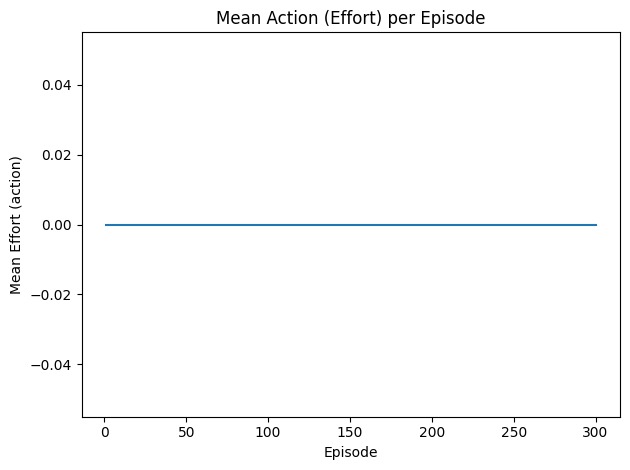

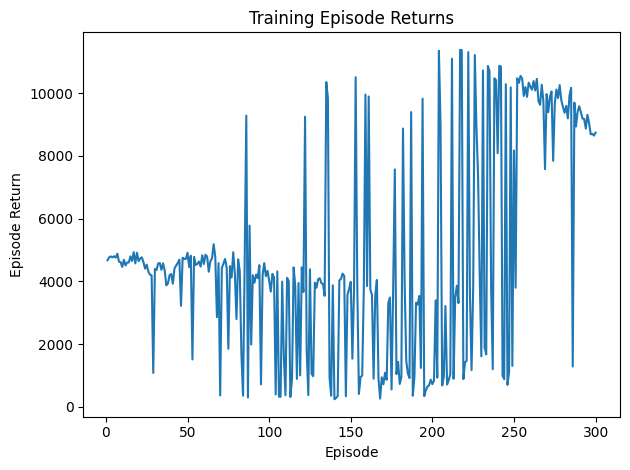


=== Summary (Evaluation) ===
Expected Return (mean over 5 eval episodes): 4955.66
Variance (eval): 937.88   |   SD (eval): 30.62
Steps-to-Target: None
Plateau Step:    None
Training Time (s): 499.04


In [ ]:
# Recreate eval env and load normalization stats
eval_env = DummyVecEnv([make_env(seed=seed, log_name="eval.monitor.csv")])
eval_env = VecNormalize.load("vecnorm.pkl", eval_env)
eval_env.training = False        # freeze running stats
eval_env.norm_reward = False     # report real (unnormalized) rewards
# Final deterministic evaluation (Expected Return & SD/Variance)
mean_return, std_return = evaluate_policy(model, eval_env, n_eval_episodes=5, deterministic=True, return_episode_rewards=False)
print(f"[EVAL] Expected Return (mean over 5 eps): {mean_return:.2f}  |  SD: {std_return:.2f}")
print(f"[CONVERGENCE] Steps-to-target (≥ {TARGET_RETURN}): {conv_tracker.steps_to_target}")
print(f"[CONVERGENCE] Plateau step (window=5, eps=2%, H=3): {conv_tracker.plateau_step}")

# read only the training monitor file
df_train = pd.read_csv("train.monitor.csv", comment="#")
returns = df_train["r"].to_numpy(dtype=np.float32)
lengths = df_train["l"].to_numpy(dtype=np.int32)

# Plot: mean effort per episode (EpisodeActionLogger)
action_df = pd.DataFrame(action_logger.episode_action_stats)
action_df["episode"] = np.arange(1, len(action_df) + 1)

plt.figure()
plt.plot(action_df["episode"], action_df["mean_action"])
plt.xlabel("Episode"); plt.ylabel("Mean Effort (action)")
plt.title("Mean Action (Effort) per Episode")
plt.tight_layout(); plt.show()

# Plot: training episode returns
plt.figure()
plt.plot(np.arange(1, len(returns) + 1), returns)
plt.xlabel("Episode"); plt.ylabel("Episode Return")
plt.title("Training Episode Returns")
plt.tight_layout(); plt.show()

# Summary table + CSVs (for report)
print("\n=== Summary (Evaluation) ===")
print(f"Expected Return (mean over 5 eval episodes): {mean_return:.2f}")
print(f"Variance (eval): {float(std_return**2):.2f}   |   SD (eval): {std_return:.2f}")
print(f"Steps-to-Target: {conv_tracker.steps_to_target}")
print(f"Plateau Step:    {conv_tracker.plateau_step}")
print(f"Training Time (s): {training_time_sec:.2f}")

pd.DataFrame({"episode": np.arange(1, len(returns)+1), "return": returns, "length": lengths}).to_csv("training_returns.csv", index=False)
action_df.to_csv("action_stats_by_episode.csv", index=False)


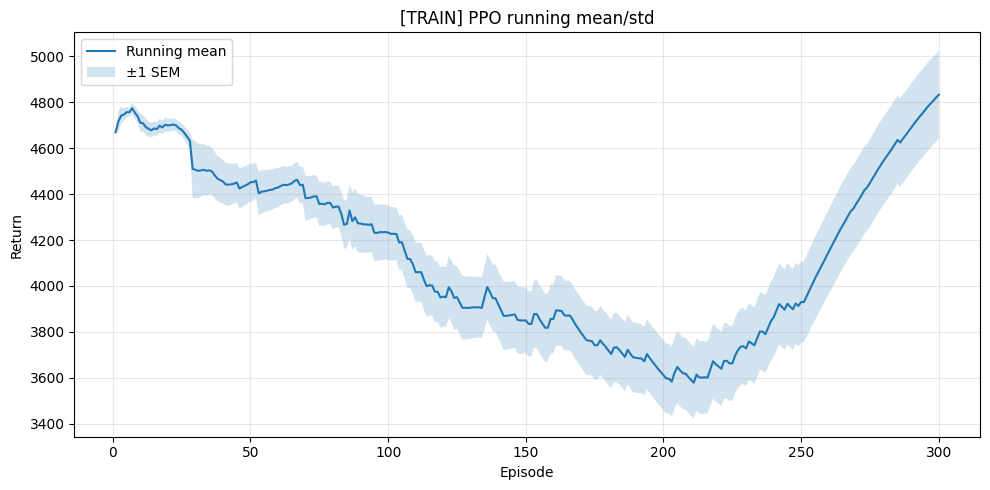

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


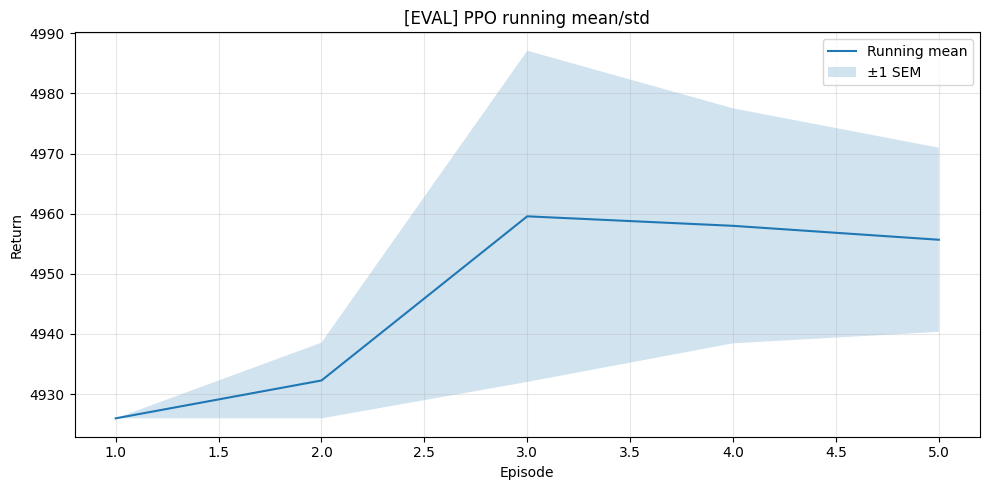

In [ ]:
def plot_running_stats(returns, title: str):
    r = np.asarray(returns, dtype=np.float64)
    if r.size == 0:
        print("No episodes logged yet in train.monitor.csv"); return
    N = r.size
    idx = np.arange(1, N + 1)
    run_mean = np.cumsum(r) / idx
    run_std  = np.zeros(N, dtype=np.float64)
    if N >= 2:
        for k in range(2, N + 1):
            run_std[k - 1] = r[:k].std(ddof=1)
    run_sem = np.where(idx > 1, run_std / np.sqrt(idx), 0.0)

    plt.figure(figsize=(10,5))
    plt.plot(idx, run_mean, label="Running mean")
    plt.fill_between(idx, run_mean - run_sem, run_mean + run_sem, alpha=0.2, label="±1 SEM")
    plt.xlabel("Episode"); plt.ylabel("Return"); plt.title(title); plt.grid(True, alpha=0.3); plt.legend()
    plt.tight_layout(); plt.show()

df = pd.read_csv("train.monitor.csv", comment="#")
returns = df["r"].to_numpy(dtype=np.float64)
plot_running_stats(returns, title="[TRAIN] PPO running mean/std")
df = pd.read_csv("eval.monitor.csv", comment="#")
returns = df["r"].to_numpy(dtype=np.float64)
plot_running_stats(returns, title="[EVAL] PPO running mean/std")


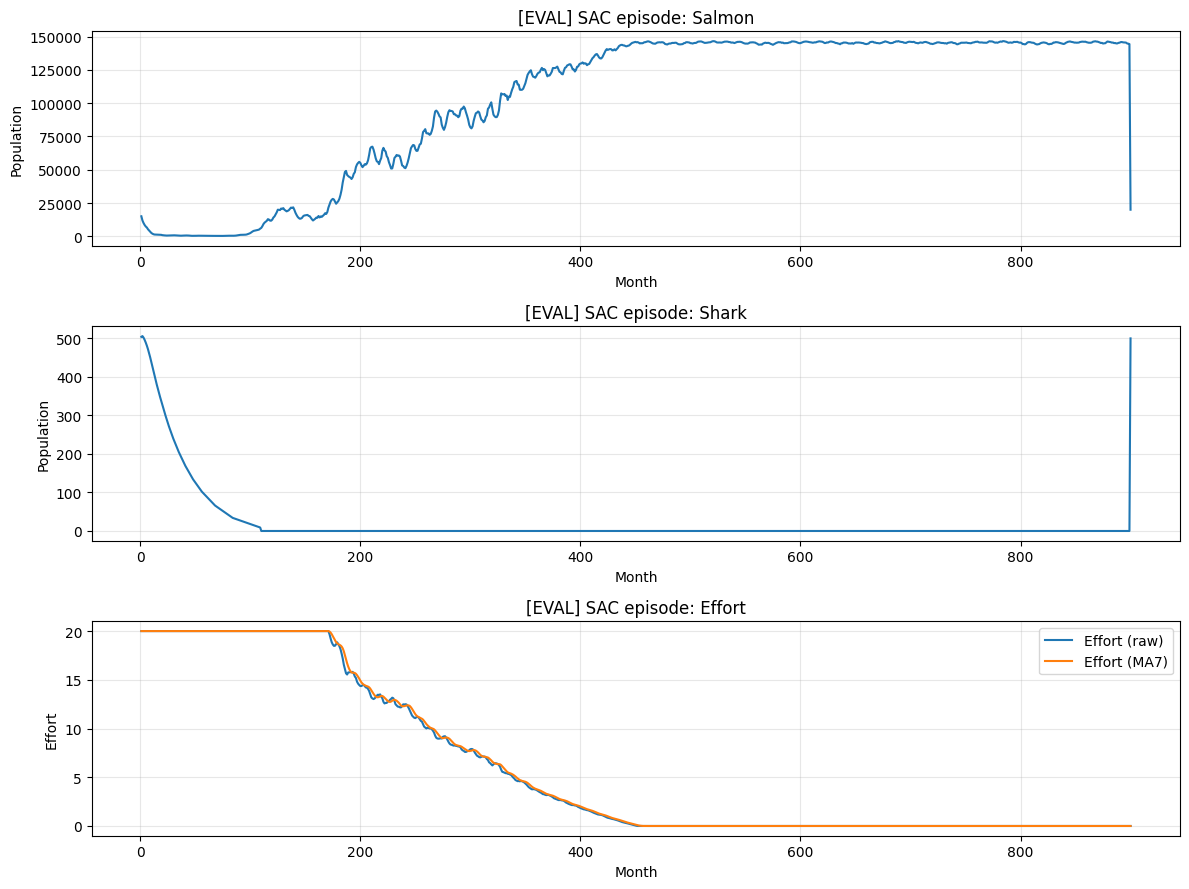

Sample episode return: 4879.8744701235555
Total salmon caught: 3746718.00
Total effort: 5496.91
Final populations at the end of episode -> Salmon: 20000.00, Shark: 500.00


In [ ]:
# single-episode trajectories
def rollout_one_episode_and_plot(model, env, smooth_effort_window=7, title_prefix="[EVAL] PPO episode"):
    def unwrap_env(vec_env):
        # VecEnv -> first sub-env, then unwrap Monitor -> base env
        base = vec_env.envs[0] if hasattr(vec_env, "envs") else vec_env
        while hasattr(base, "env"):
            base = base.env
        return base

    # CHANGE: VecEnv.reset() returns obs only (no info)
    obs = env.reset()
    done = False

    # use full-step index 1..horizon for x-axis (not month % 12)
    t_idx, salmon_hist, shark_hist, effort_hist, reward_hist = [], [], [], [], []

    total_salmon_caught = 0.0
    total_effort = 0.0

    while not done:
        base_env = unwrap_env(env)
        t_idx.append(len(t_idx) + 1)  # 1..900

        # deterministic policy for evaluation
        action, _ = model.predict(obs, deterministic=True)

        # CHANGE: VecEnv step signature is (obs, rewards, dones, infos)
        obs2, reward, done, infos = env.step(action)

        # coerce VecEnv returns to scalars
        if isinstance(done, (np.ndarray, list)):
            done = bool(done[0])
        info = infos[0] if isinstance(infos, (list, tuple)) and len(infos) > 0 else {}
        reward = float(np.array(reward).reshape(-1)[0])

        # pull states/effort (we exposed them in OceanEnv.step info)
        effort = float(info.get("effort", float(np.array(action).reshape(-1)[0])))
        catch = float(info.get("salmon_caught", 0.0))
        s = float(getattr(base_env, "salmon", float("nan")))
        k = float(getattr(base_env, "shark", float("nan")))

        effort_hist.append(effort)
        salmon_hist.append(s)
        shark_hist.append(k)
        reward_hist.append(reward)
        total_effort += effort
        total_salmon_caught += catch
        obs = obs2

    final_env = unwrap_env(env)
    final_salmon = float(getattr(final_env, "salmon", float("nan")))
    final_shark  = float(getattr(final_env, "shark",  float("nan")))

    # moving average for effort (same shape as effort_hist)
    def _moving_avg(x, k):
        if k <= 1 or len(x) < 2:
            return np.asarray(x, dtype=float)
        x = np.asarray(x, dtype=float)
        k = min(k, len(x))
        c = np.cumsum(np.insert(x, 0, 0.0))
        ma = (c[k:] - c[:-k]) / float(k)
        pad_left = np.full(k - 1, ma[0], dtype=float)
        return np.concatenate([pad_left, ma])

    effort_smooth = _moving_avg(effort_hist, smooth_effort_window)

    # --- three-panel plot: Salmon, Shark, Effort(+MA) over 1..900 months ---
    nrows = 3
    plt.figure(figsize=(12, 9))

    ax1 = plt.subplot(nrows, 1, 1)
    ax1.plot(t_idx, salmon_hist)
    ax1.set_title(f"{title_prefix}: Salmon")
    ax1.set_xlabel("Month")
    ax1.set_ylabel("Population")
    ax1.grid(True, alpha=0.3)

    ax2 = plt.subplot(nrows, 1, 2, sharex=ax1)
    ax2.plot(t_idx, shark_hist)
    ax2.set_title(f"{title_prefix}: Shark")
    ax2.set_xlabel("Month")
    ax2.set_ylabel("Population")
    ax2.grid(True, alpha=0.3)

    ax3 = plt.subplot(nrows, 1, 3, sharex=ax1)
    ax3.plot(t_idx, effort_hist, label="Effort (raw)")
    if len(effort_hist) >= 2:
        ax3.plot(t_idx, effort_smooth, label=f"Effort (MA{min(smooth_effort_window, len(effort_hist))})")
    ax3.set_title(f"{title_prefix}: Effort")
    ax3.set_xlabel("Month")
    ax3.set_ylabel("Effort")
    ax3.grid(True, alpha=0.3)
    ax3.legend()

    plt.tight_layout()
    plt.show()

    return {
        "months": t_idx,
        "salmon": salmon_hist if salmon_hist else None,
        "shark": shark_hist if shark_hist else None,
        "effort": effort_hist,
        "effort_smooth": effort_smooth,
        "ep_return": float(np.sum(reward_hist)),
        "total_caught": float(total_salmon_caught),
        "total_effort": float(total_effort),
        "final_salmon": final_salmon,
        "final_shark": final_shark,
    }
# Run once to reproduce the SAC-style single-episode figure
traj = rollout_one_episode_and_plot(model, eval_env, smooth_effort_window=7, title_prefix="[EVAL] PPO episode")
print("Sample episode return:", traj["ep_return"])
print(f"Total salmon caught: {traj['total_caught']:.2f}")
print(f"Total effort: {traj['total_effort']:.2f}")
print(f"Final populations at the end of episode -> Salmon: {traj['final_salmon']:.2f}, Shark: {traj['final_shark']:.2f}")


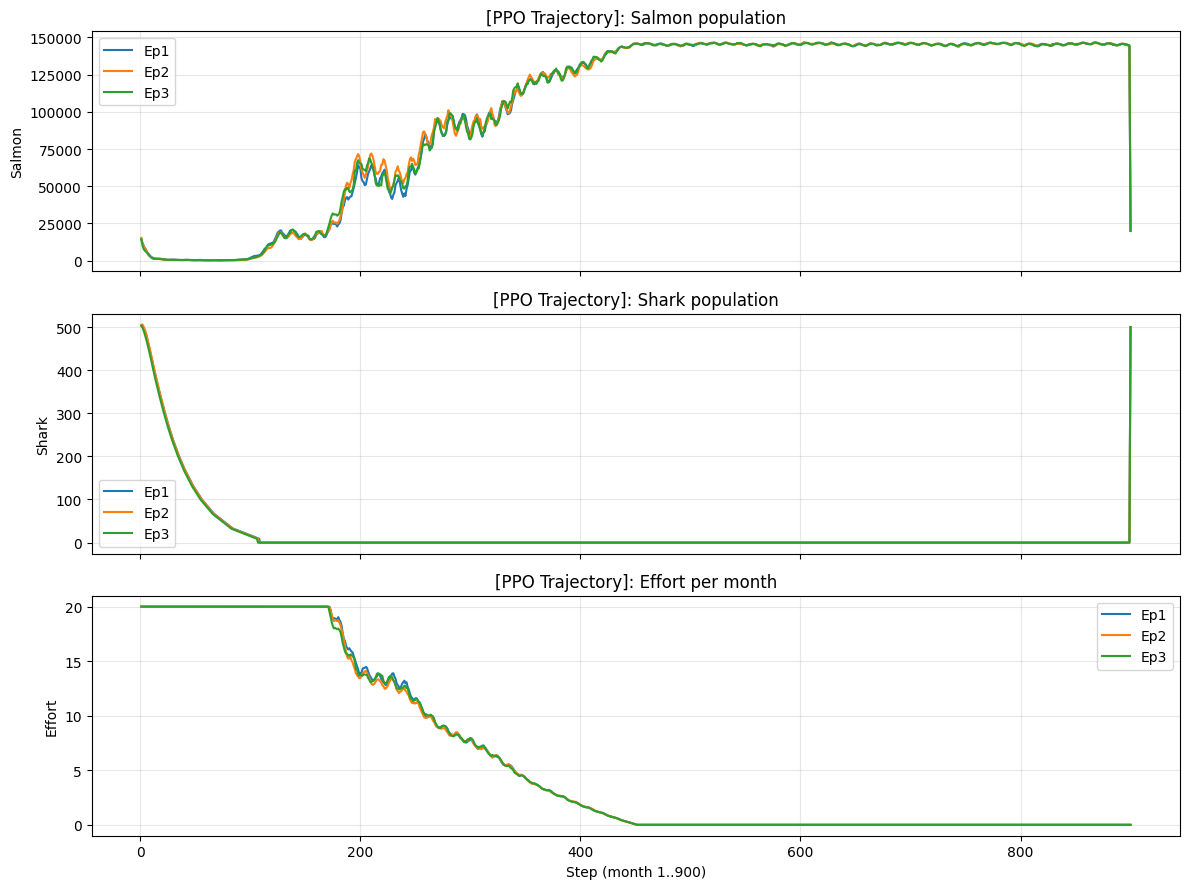

In [ ]:
def eval_and_plot_full_trajectories(model, env, episodes=3, title_prefix="[PPO Trajectory]"):
    def unwrap_env(vec_env):
        # VecEnv -> first sub-env, then unwrap Monitor -> base env
        base = vec_env.envs[0] if hasattr(vec_env, "envs") else vec_env
        while hasattr(base, "env"):
            base = base.env
        return base

    fig, axes = plt.subplots(3, 1, figsize=(12, 9), sharex=True)

    for ep in range(episodes):
        # VecEnv.reset() -> obs only
        obs = env.reset()
        done = False

        # step-index for 1..horizon so we see the full 900-month trajectory
        t_idx, s_hist, k_hist, e_hist = [], [], [], []

        while not done:
            base_env = unwrap_env(env)

            # keep full-step index (1..horizon), not month mod 12
            t_idx.append(len(t_idx) + 1)

            # deterministic eval policy
            action, _ = model.predict(obs, deterministic=True)

            # VecEnv step: (obs, rewards, dones, infos)
            obs2, reward, done, infos = env.step(action)

            # coerce list/array returns from VecEnv
            if isinstance(done, (np.ndarray, list)):
                done = bool(done[0])
            info = infos[0] if isinstance(infos, (list, tuple)) and len(infos) > 0 else {}

            # pull logged state/effort; fall back to action if info missing
            effort = float(info.get("effort", float(np.array(action).reshape(-1)[0])))
            s = float(getattr(base_env, "salmon", float("nan")))
            k = float(getattr(base_env, "shark", float("nan")))

            e_hist.append(effort)
            s_hist.append(s)
            k_hist.append(k)
            obs = obs2

        axes[0].plot(t_idx, s_hist, label=f"Ep{ep+1}")
        axes[1].plot(t_idx, k_hist, label=f"Ep{ep+1}")
        axes[2].plot(t_idx, e_hist, label=f"Ep{ep+1}")

    axes[0].set_title(f"{title_prefix}: Salmon population")
    axes[1].set_title(f"{title_prefix}: Shark population")
    axes[2].set_title(f"{title_prefix}: Effort per month")

    axes[2].set_xlabel("Step (month 1..900)")
    axes[0].set_ylabel("Salmon")
    axes[1].set_ylabel("Shark")
    axes[2].set_ylabel("Effort")

    for ax in axes:
        ax.grid(True, alpha=0.3)
        ax.legend()

    plt.tight_layout()
    plt.show()
eval_and_plot_full_trajectories(model, eval_env, episodes=3, title_prefix="[PPO Trajectory]")


In [103]:
import numpy as np
import math

def evaluate_returns_vec(model, vec_env, episodes: int = 1000, deterministic: bool = True):
    """
    Works with SB3 VecEnv (e.g., DummyVecEnv + VecNormalize).
    Captures episode return, total salmon caught, total effort,
    final salmon/shark, and salmon/shark at 75th year (month=900).
    """
    returns = []
    episode_stats = []

    for ep in range(episodes):
        # VecEnv.reset() -> obs only
        obs = vec_env.reset()
        done = False
        ep_ret = 0.0
        total_caught = 0.0
        total_effort = 0.0
        final_salmon = float("nan")
        final_shark  = float("nan")

        # capture at 75th year (month 900) once per episode
        salmon_75y = float("nan")
        shark_75y  = float("nan")
        captured_75y = False

        while not done:
            # deterministic eval by default
            action, _ = model.predict(obs, deterministic=deterministic)

            # VecEnv step -> (obs, rewards, dones, infos)
            obs2, reward, dones, infos = vec_env.step(action)

            # coerce to scalars
            r = float(np.array(reward).reshape(-1)[0])
            info = infos[0] if isinstance(infos, (list, tuple)) and len(infos) > 0 else {}

            ep_ret += r
            total_caught += float(info.get("salmon_caught", 0.0))

            # effort from info (fallback to action if missing)
            effort_val = info.get("effort", None)
            if effort_val is None:
                effort_val = float(np.array(action).reshape(-1)[0])
            total_effort += float(effort_val)

            # month is cumulative in your env (0 -> 900)
            month_val = int(info.get("month", -1))
            if (not captured_75y) and month_val >= 75 * 12:
                salmon_75y = float(info.get("salmon", float("nan")))
                shark_75y  = float(info.get("shark",  float("nan")))
                captured_75y = True

            done = bool(dones[0]) if isinstance(dones, (np.ndarray, list)) else bool(dones)
            obs = obs2

            if done:
                # unwrap to base env to read final state safely
                base = vec_env.envs[0]
                while hasattr(base, "env"):
                    base = base.env
                final_salmon = float(getattr(base, "salmon", float("nan")))
                final_shark  = float(getattr(base, "shark",  float("nan")))

        returns.append(ep_ret)
        episode_stats.append(
            dict(
                episode=ep + 1,
                reward=ep_ret,
                salmon_caught=total_caught,
                effort=total_effort,
                final_salmon=final_salmon,
                final_shark=final_shark,
                salmon_75y=salmon_75y,
                shark_75y=shark_75y,
            )
        )

    arr = np.asarray(returns, dtype=np.float64)
    stats = {
        "episodes": int(episodes),
        "mean": float(arr.mean()) if arr.size else 0.0,
        "median": float(np.median(arr)) if arr.size else 0.0,
        "std": float(arr.std(ddof=1)) if arr.size > 1 else 0.0,
        "min": float(arr.min()) if arr.size else 0.0,
        "max": float(arr.max()) if arr.size else 0.0,
    }
    return returns, stats, episode_stats

returns, stats, episode_stats = evaluate_returns_vec(model, eval_env, episodes=1000)

print("[EVAL] Episodes:", stats["episodes"])
print(f"[EVAL] Mean: {stats['mean']:.2f}  Median: {stats['median']:.2f}  Std: {stats['std']:.2f}")
print(f"[EVAL] Min: {stats['min']:.2f}  Max: {stats['max']:.2f}")

# Averages for sustainability metrics
avg_salmon      = np.mean([row["salmon_caught"] for row in episode_stats])
avg_effort      = np.mean([row["effort"] for row in episode_stats])
avg_final_salmon= np.mean([row["final_salmon"] for row in episode_stats])
avg_final_shark = np.mean([row["final_shark"] for row in episode_stats])

print(
    f"\nAverages over {stats['episodes']} episodes:\n"
    f"  salmon_caught = {avg_salmon:.0f}\n"
    f"  effort        = {avg_effort:.0f}\n"
    f"  final_salmon  = {avg_final_salmon:.0f}\n"
    f"  final_shark   = {avg_final_shark:.0f}"
)

# 75th-year populations (mean across episodes)
avg_salmon_75y = np.nanmean([row["salmon_75y"] for row in episode_stats])
avg_shark_75y  = np.nanmean([row["shark_75y"]  for row in episode_stats])
print(
    f"\nPopulations at 75th year (averaged over episodes):\n"
    f"  salmon_75y = {avg_salmon_75y:.0f}\n"
    f"  shark_75y  = {avg_shark_75y:.0f}"
)

[EVAL] Episodes: 1000
[EVAL] Mean: 22.88  Median: 22.86  Std: 1.48
[EVAL] Min: 20.27  Max: 65.57

Averages over 1000 episodes:
  salmon_caught = 11920047
  effort        = 9410
  final_salmon  = 20000
  final_shark   = 500

Populations at 75th year (averaged over episodes):
  salmon_75y = 104002
  shark_75y  = 0


### ent_coef = 0.05

In [104]:
model = PPO.load("./best_ppo/best_model_ent_coef_05")

[EVAL] Expected Return (mean over 5 eps): 5090.69  |  SD: 30.54
[CONVERGENCE] Steps-to-target (≥ 10000.0): None
[CONVERGENCE] Plateau step (window=5, eps=2%, H=3): None


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


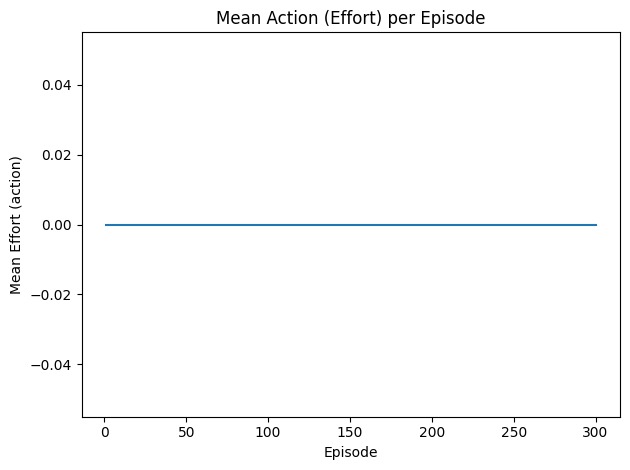

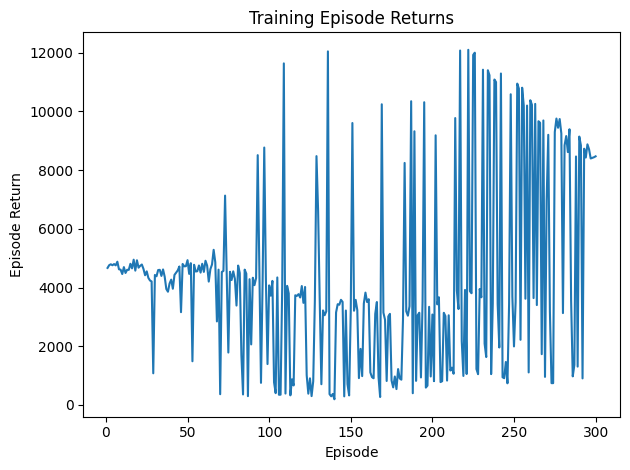


=== Summary (Evaluation) ===
Expected Return (mean over 5 eval episodes): 5090.69
Variance (eval): 932.39   |   SD (eval): 30.54
Steps-to-Target: None
Plateau Step:    None
Training Time (s): 505.65


In [ ]:
# Recreate eval env and load normalization stats
eval_env = DummyVecEnv([make_env(seed=seed, log_name="eval.monitor.csv")])
eval_env = VecNormalize.load("vecnorm.pkl", eval_env)
eval_env.training = False        # freeze running stats
eval_env.norm_reward = False     # report real (unnormalized) rewards
# Final deterministic evaluation (Expected Return & SD/Variance)
mean_return, std_return = evaluate_policy(model, eval_env, n_eval_episodes=5, deterministic=True, return_episode_rewards=False)
print(f"[EVAL] Expected Return (mean over 5 eps): {mean_return:.2f}  |  SD: {std_return:.2f}")
print(f"[CONVERGENCE] Steps-to-target (≥ {TARGET_RETURN}): {conv_tracker.steps_to_target}")
print(f"[CONVERGENCE] Plateau step (window=5, eps=2%, H=3): {conv_tracker.plateau_step}")

# read only the training monitor file
df_train = pd.read_csv("train.monitor.csv", comment="#")
returns = df_train["r"].to_numpy(dtype=np.float32)
lengths = df_train["l"].to_numpy(dtype=np.int32)

# Plot: mean effort per episode (EpisodeActionLogger)
action_df = pd.DataFrame(action_logger.episode_action_stats)
action_df["episode"] = np.arange(1, len(action_df) + 1)

plt.figure()
plt.plot(action_df["episode"], action_df["mean_action"])
plt.xlabel("Episode"); plt.ylabel("Mean Effort (action)")
plt.title("Mean Action (Effort) per Episode")
plt.tight_layout(); plt.show()

# Plot: training episode returns
plt.figure()
plt.plot(np.arange(1, len(returns) + 1), returns)
plt.xlabel("Episode"); plt.ylabel("Episode Return")
plt.title("Training Episode Returns")
plt.tight_layout(); plt.show()

# Summary table + CSVs (for report)
print("\n=== Summary (Evaluation) ===")
print(f"Expected Return (mean over 5 eval episodes): {mean_return:.2f}")
print(f"Variance (eval): {float(std_return**2):.2f}   |   SD (eval): {std_return:.2f}")
print(f"Steps-to-Target: {conv_tracker.steps_to_target}")
print(f"Plateau Step:    {conv_tracker.plateau_step}")
print(f"Training Time (s): {training_time_sec:.2f}")

pd.DataFrame({"episode": np.arange(1, len(returns)+1), "return": returns, "length": lengths}).to_csv("training_returns.csv", index=False)
action_df.to_csv("action_stats_by_episode.csv", index=False)


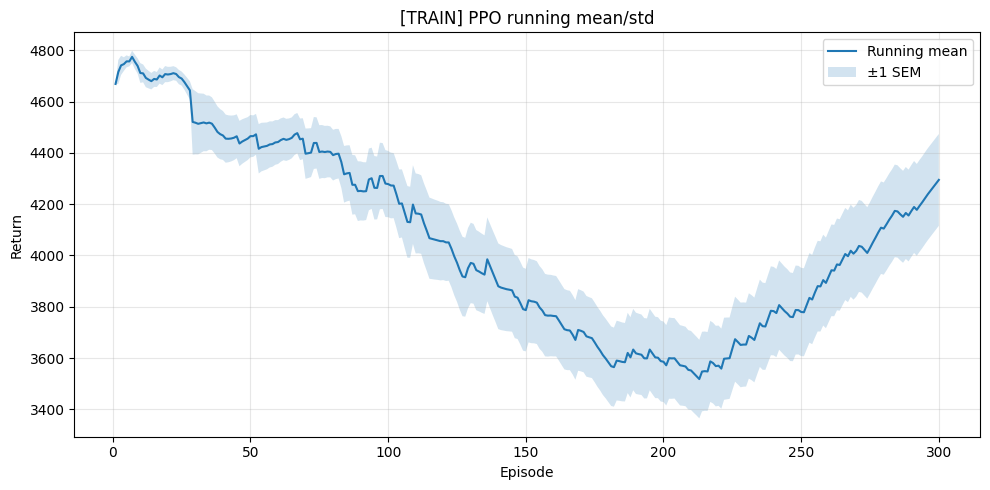

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


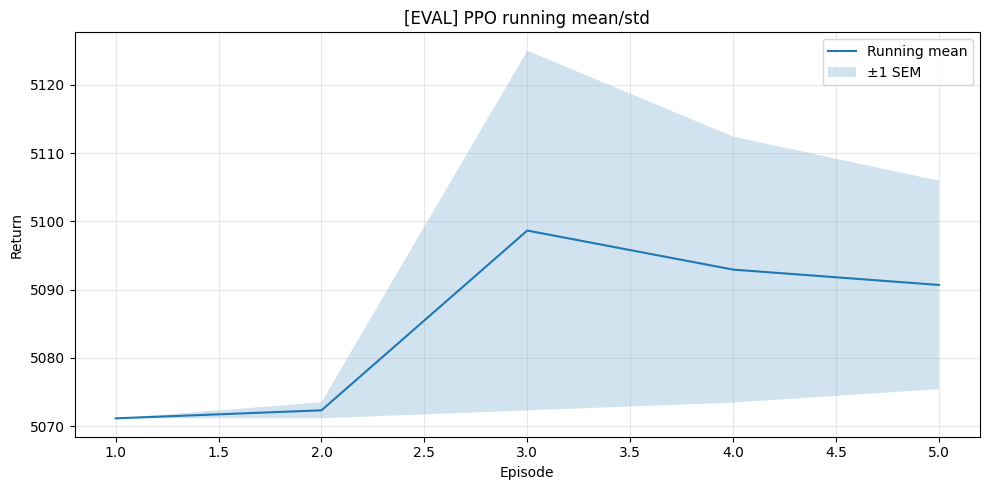

In [ ]:
def plot_running_stats(returns, title: str):
    r = np.asarray(returns, dtype=np.float64)
    if r.size == 0:
        print("No episodes logged yet in train.monitor.csv"); return
    N = r.size
    idx = np.arange(1, N + 1)
    run_mean = np.cumsum(r) / idx
    run_std  = np.zeros(N, dtype=np.float64)
    if N >= 2:
        for k in range(2, N + 1):
            run_std[k - 1] = r[:k].std(ddof=1)
    run_sem = np.where(idx > 1, run_std / np.sqrt(idx), 0.0)

    plt.figure(figsize=(10,5))
    plt.plot(idx, run_mean, label="Running mean")
    plt.fill_between(idx, run_mean - run_sem, run_mean + run_sem, alpha=0.2, label="±1 SEM")
    plt.xlabel("Episode"); plt.ylabel("Return"); plt.title(title); plt.grid(True, alpha=0.3); plt.legend()
    plt.tight_layout(); plt.show()

df = pd.read_csv("train.monitor.csv", comment="#")
returns = df["r"].to_numpy(dtype=np.float64)
plot_running_stats(returns, title="[TRAIN] PPO running mean/std")
df = pd.read_csv("eval.monitor.csv", comment="#")
returns = df["r"].to_numpy(dtype=np.float64)
plot_running_stats(returns, title="[EVAL] PPO running mean/std")


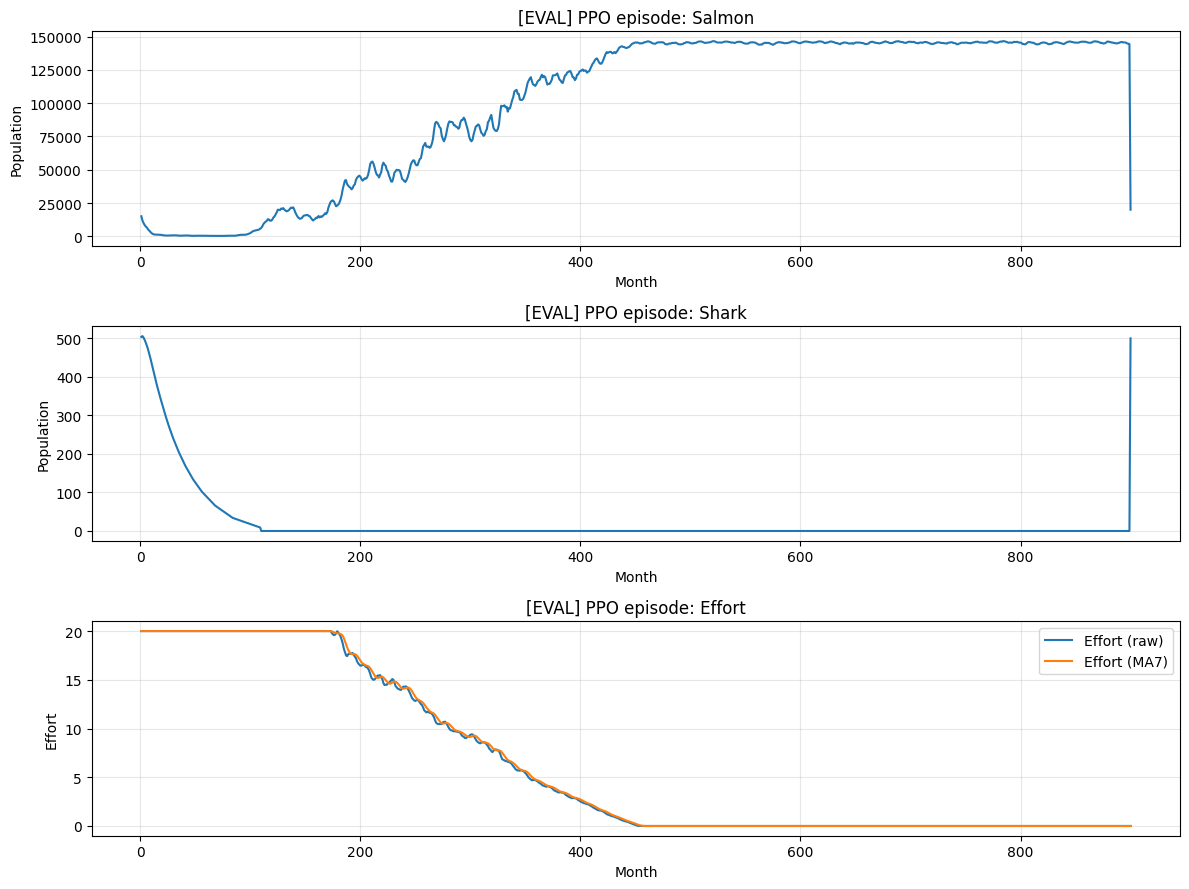

Sample episode return: 5011.707615011837
Total salmon caught: 3881987.00
Total effort: 5840.50
Final populations at the end of episode -> Salmon: 20000.00, Shark: 500.00


In [ ]:
# single-episode trajectories
def rollout_one_episode_and_plot(model, env, smooth_effort_window=7, title_prefix="[EVAL] PPO episode"):
    def unwrap_env(vec_env):
        # VecEnv -> first sub-env, then unwrap Monitor -> base env
        base = vec_env.envs[0] if hasattr(vec_env, "envs") else vec_env
        while hasattr(base, "env"):
            base = base.env
        return base

    # CHANGE: VecEnv.reset() returns obs only (no info)
    obs = env.reset()
    done = False

    # use full-step index 1..horizon for x-axis (not month % 12)
    t_idx, salmon_hist, shark_hist, effort_hist, reward_hist = [], [], [], [], []

    total_salmon_caught = 0.0
    total_effort = 0.0

    while not done:
        base_env = unwrap_env(env)
        t_idx.append(len(t_idx) + 1)  # 1..900

        # deterministic policy for evaluation
        action, _ = model.predict(obs, deterministic=True)

        # CHANGE: VecEnv step signature is (obs, rewards, dones, infos)
        obs2, reward, done, infos = env.step(action)

        # coerce VecEnv returns to scalars
        if isinstance(done, (np.ndarray, list)):
            done = bool(done[0])
        info = infos[0] if isinstance(infos, (list, tuple)) and len(infos) > 0 else {}
        reward = float(np.array(reward).reshape(-1)[0])

        # pull states/effort (we exposed them in OceanEnv.step info)
        effort = float(info.get("effort", float(np.array(action).reshape(-1)[0])))
        catch = float(info.get("salmon_caught", 0.0))
        s = float(getattr(base_env, "salmon", float("nan")))
        k = float(getattr(base_env, "shark", float("nan")))

        effort_hist.append(effort)
        salmon_hist.append(s)
        shark_hist.append(k)
        reward_hist.append(reward)
        total_effort += effort
        total_salmon_caught += catch
        obs = obs2

    final_env = unwrap_env(env)
    final_salmon = float(getattr(final_env, "salmon", float("nan")))
    final_shark  = float(getattr(final_env, "shark",  float("nan")))

    # moving average for effort (same shape as effort_hist)
    def _moving_avg(x, k):
        if k <= 1 or len(x) < 2:
            return np.asarray(x, dtype=float)
        x = np.asarray(x, dtype=float)
        k = min(k, len(x))
        c = np.cumsum(np.insert(x, 0, 0.0))
        ma = (c[k:] - c[:-k]) / float(k)
        pad_left = np.full(k - 1, ma[0], dtype=float)
        return np.concatenate([pad_left, ma])

    effort_smooth = _moving_avg(effort_hist, smooth_effort_window)

    # --- three-panel plot: Salmon, Shark, Effort(+MA) over 1..900 months ---
    nrows = 3
    plt.figure(figsize=(12, 9))

    ax1 = plt.subplot(nrows, 1, 1)
    ax1.plot(t_idx, salmon_hist)
    ax1.set_title(f"{title_prefix}: Salmon")
    ax1.set_xlabel("Month")
    ax1.set_ylabel("Population")
    ax1.grid(True, alpha=0.3)

    ax2 = plt.subplot(nrows, 1, 2, sharex=ax1)
    ax2.plot(t_idx, shark_hist)
    ax2.set_title(f"{title_prefix}: Shark")
    ax2.set_xlabel("Month")
    ax2.set_ylabel("Population")
    ax2.grid(True, alpha=0.3)

    ax3 = plt.subplot(nrows, 1, 3, sharex=ax1)
    ax3.plot(t_idx, effort_hist, label="Effort (raw)")
    if len(effort_hist) >= 2:
        ax3.plot(t_idx, effort_smooth, label=f"Effort (MA{min(smooth_effort_window, len(effort_hist))})")
    ax3.set_title(f"{title_prefix}: Effort")
    ax3.set_xlabel("Month")
    ax3.set_ylabel("Effort")
    ax3.grid(True, alpha=0.3)
    ax3.legend()

    plt.tight_layout()
    plt.show()

    return {
        "months": t_idx,
        "salmon": salmon_hist if salmon_hist else None,
        "shark": shark_hist if shark_hist else None,
        "effort": effort_hist,
        "effort_smooth": effort_smooth,
        "ep_return": float(np.sum(reward_hist)),
        "total_caught": float(total_salmon_caught),
        "total_effort": float(total_effort),
        "final_salmon": final_salmon,
        "final_shark": final_shark,
    }
# Run once to reproduce the SAC-style single-episode figure
traj = rollout_one_episode_and_plot(model, eval_env, smooth_effort_window=7, title_prefix="[EVAL] PPO episode")
print("Sample episode return:", traj["ep_return"])
print(f"Total salmon caught: {traj['total_caught']:.2f}")
print(f"Total effort: {traj['total_effort']:.2f}")
print(f"Final populations at the end of episode -> Salmon: {traj['final_salmon']:.2f}, Shark: {traj['final_shark']:.2f}")


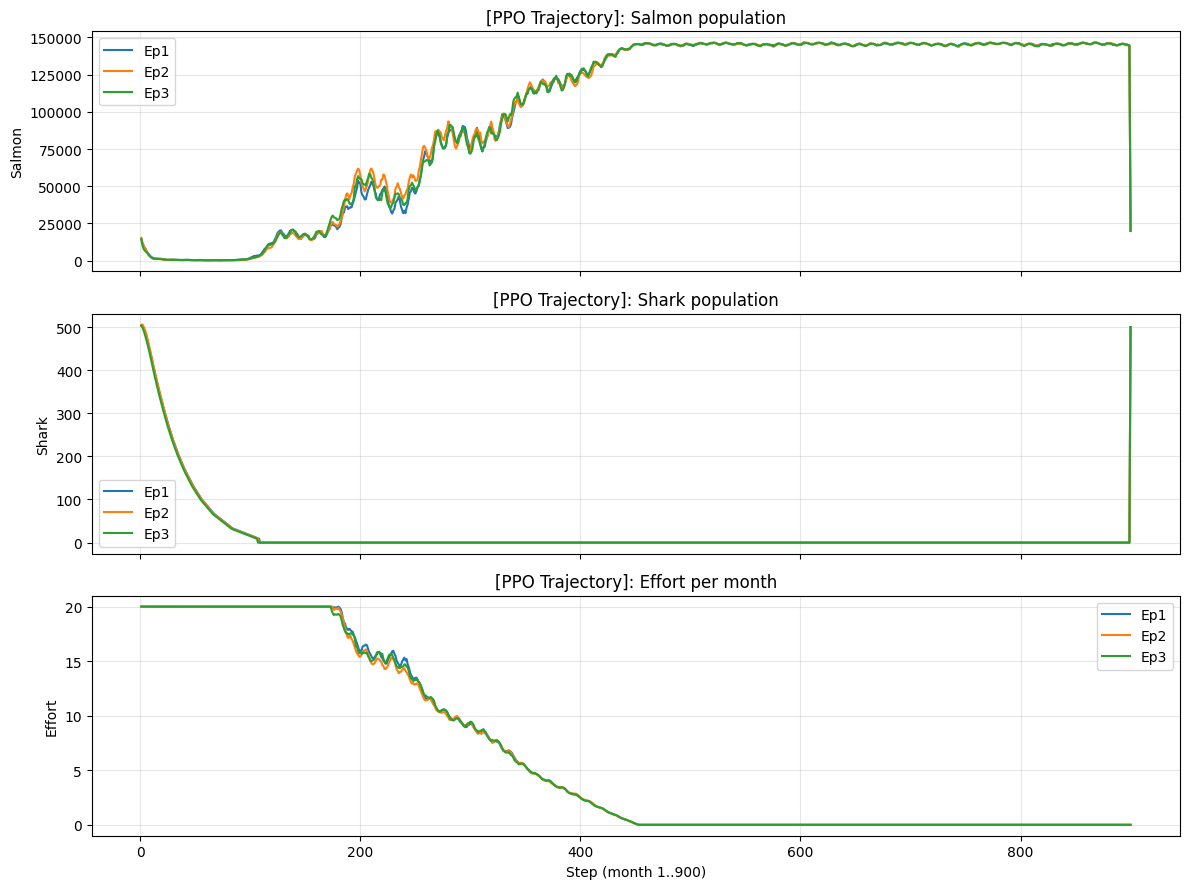

In [ ]:
def eval_and_plot_full_trajectories(model, env, episodes=3, title_prefix="[PPO Trajectory]"):
    def unwrap_env(vec_env):
        # VecEnv -> first sub-env, then unwrap Monitor -> base env
        base = vec_env.envs[0] if hasattr(vec_env, "envs") else vec_env
        while hasattr(base, "env"):
            base = base.env
        return base

    fig, axes = plt.subplots(3, 1, figsize=(12, 9), sharex=True)

    for ep in range(episodes):
        # VecEnv.reset() -> obs only
        obs = env.reset()
        done = False

        # step-index for 1..horizon so we see the full 900-month trajectory
        t_idx, s_hist, k_hist, e_hist = [], [], [], []

        while not done:
            base_env = unwrap_env(env)

            # keep full-step index (1..horizon), not month mod 12
            t_idx.append(len(t_idx) + 1)

            # deterministic eval policy
            action, _ = model.predict(obs, deterministic=True)

            # VecEnv step: (obs, rewards, dones, infos)
            obs2, reward, done, infos = env.step(action)

            # coerce list/array returns from VecEnv
            if isinstance(done, (np.ndarray, list)):
                done = bool(done[0])
            info = infos[0] if isinstance(infos, (list, tuple)) and len(infos) > 0 else {}

            # pull logged state/effort; fall back to action if info missing
            effort = float(info.get("effort", float(np.array(action).reshape(-1)[0])))
            s = float(getattr(base_env, "salmon", float("nan")))
            k = float(getattr(base_env, "shark", float("nan")))

            e_hist.append(effort)
            s_hist.append(s)
            k_hist.append(k)
            obs = obs2

        axes[0].plot(t_idx, s_hist, label=f"Ep{ep+1}")
        axes[1].plot(t_idx, k_hist, label=f"Ep{ep+1}")
        axes[2].plot(t_idx, e_hist, label=f"Ep{ep+1}")

    axes[0].set_title(f"{title_prefix}: Salmon population")
    axes[1].set_title(f"{title_prefix}: Shark population")
    axes[2].set_title(f"{title_prefix}: Effort per month")

    axes[2].set_xlabel("Step (month 1..900)")
    axes[0].set_ylabel("Salmon")
    axes[1].set_ylabel("Shark")
    axes[2].set_ylabel("Effort")

    for ax in axes:
        ax.grid(True, alpha=0.3)
        ax.legend()

    plt.tight_layout()
    plt.show()
eval_and_plot_full_trajectories(model, eval_env, episodes=3, title_prefix="[PPO Trajectory]")


In [105]:
import numpy as np
import math

def evaluate_returns_vec(model, vec_env, episodes: int = 1000, deterministic: bool = True):
    """
    Works with SB3 VecEnv (e.g., DummyVecEnv + VecNormalize).
    Captures episode return, total salmon caught, total effort,
    final salmon/shark, and salmon/shark at 75th year (month=900).
    """
    returns = []
    episode_stats = []

    for ep in range(episodes):
        # VecEnv.reset() -> obs only
        obs = vec_env.reset()
        done = False
        ep_ret = 0.0
        total_caught = 0.0
        total_effort = 0.0
        final_salmon = float("nan")
        final_shark  = float("nan")

        # capture at 75th year (month 900) once per episode
        salmon_75y = float("nan")
        shark_75y  = float("nan")
        captured_75y = False

        while not done:
            # deterministic eval by default
            action, _ = model.predict(obs, deterministic=deterministic)

            # VecEnv step -> (obs, rewards, dones, infos)
            obs2, reward, dones, infos = vec_env.step(action)

            # coerce to scalars
            r = float(np.array(reward).reshape(-1)[0])
            info = infos[0] if isinstance(infos, (list, tuple)) and len(infos) > 0 else {}

            ep_ret += r
            total_caught += float(info.get("salmon_caught", 0.0))

            # effort from info (fallback to action if missing)
            effort_val = info.get("effort", None)
            if effort_val is None:
                effort_val = float(np.array(action).reshape(-1)[0])
            total_effort += float(effort_val)

            # month is cumulative in your env (0 -> 900)
            month_val = int(info.get("month", -1))
            if (not captured_75y) and month_val >= 75 * 12:
                salmon_75y = float(info.get("salmon", float("nan")))
                shark_75y  = float(info.get("shark",  float("nan")))
                captured_75y = True

            done = bool(dones[0]) if isinstance(dones, (np.ndarray, list)) else bool(dones)
            obs = obs2

            if done:
                # unwrap to base env to read final state safely
                base = vec_env.envs[0]
                while hasattr(base, "env"):
                    base = base.env
                final_salmon = float(getattr(base, "salmon", float("nan")))
                final_shark  = float(getattr(base, "shark",  float("nan")))

        returns.append(ep_ret)
        episode_stats.append(
            dict(
                episode=ep + 1,
                reward=ep_ret,
                salmon_caught=total_caught,
                effort=total_effort,
                final_salmon=final_salmon,
                final_shark=final_shark,
                salmon_75y=salmon_75y,
                shark_75y=shark_75y,
            )
        )

    arr = np.asarray(returns, dtype=np.float64)
    stats = {
        "episodes": int(episodes),
        "mean": float(arr.mean()) if arr.size else 0.0,
        "median": float(np.median(arr)) if arr.size else 0.0,
        "std": float(arr.std(ddof=1)) if arr.size > 1 else 0.0,
        "min": float(arr.min()) if arr.size else 0.0,
        "max": float(arr.max()) if arr.size else 0.0,
    }
    return returns, stats, episode_stats

returns, stats, episode_stats = evaluate_returns_vec(model, eval_env, episodes=1000)

print("[EVAL] Episodes:", stats["episodes"])
print(f"[EVAL] Mean: {stats['mean']:.2f}  Median: {stats['median']:.2f}  Std: {stats['std']:.2f}")
print(f"[EVAL] Min: {stats['min']:.2f}  Max: {stats['max']:.2f}")

# Averages for sustainability metrics
avg_salmon      = np.mean([row["salmon_caught"] for row in episode_stats])
avg_effort      = np.mean([row["effort"] for row in episode_stats])
avg_final_salmon= np.mean([row["final_salmon"] for row in episode_stats])
avg_final_shark = np.mean([row["final_shark"] for row in episode_stats])

print(
    f"\nAverages over {stats['episodes']} episodes:\n"
    f"  salmon_caught = {avg_salmon:.0f}\n"
    f"  effort        = {avg_effort:.0f}\n"
    f"  final_salmon  = {avg_final_salmon:.0f}\n"
    f"  final_shark   = {avg_final_shark:.0f}"
)

# 75th-year populations (mean across episodes)
avg_salmon_75y = np.nanmean([row["salmon_75y"] for row in episode_stats])
avg_shark_75y  = np.nanmean([row["shark_75y"]  for row in episode_stats])
print(
    f"\nPopulations at 75th year (averaged over episodes):\n"
    f"  salmon_75y = {avg_salmon_75y:.0f}\n"
    f"  shark_75y  = {avg_shark_75y:.0f}"
)


[EVAL] Episodes: 1000
[EVAL] Mean: 23.12  Median: 23.13  Std: 0.16
[EVAL] Min: 22.48  Max: 23.61

Averages over 1000 episodes:
  salmon_caught = 12112682
  effort        = 9608
  final_salmon  = 20000
  final_shark   = 500

Populations at 75th year (averaged over episodes):
  salmon_75y = 100482
  shark_75y  = 0


### ent_coef = 0.10

[EVAL] Expected Return (mean over 5 eps): 1582.63  |  SD: 2.27
[CONVERGENCE] Steps-to-target (≥ 10000.0): None
[CONVERGENCE] Plateau step (window=5, eps=2%, H=3): None


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


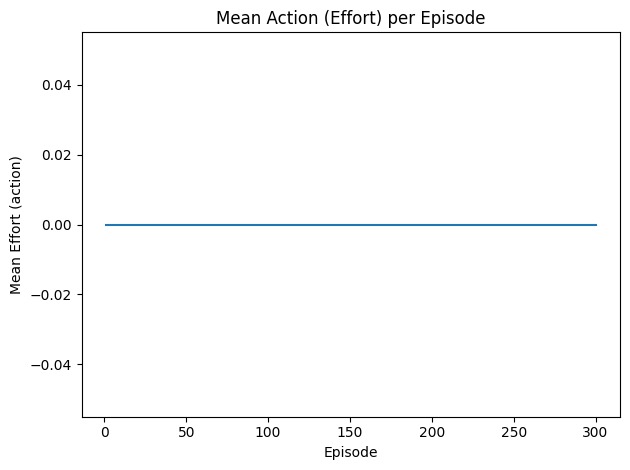

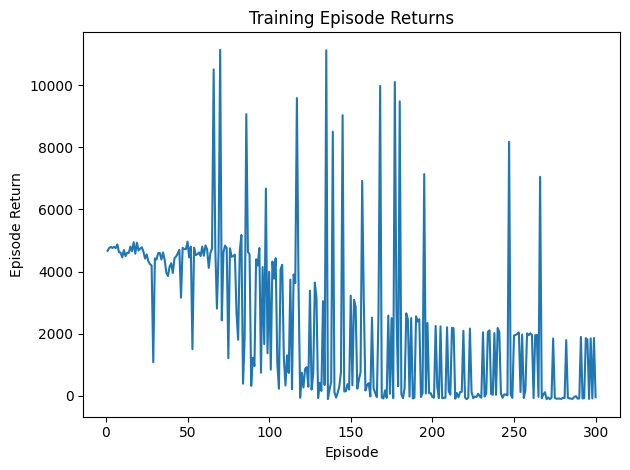


=== Summary (Evaluation) ===
Expected Return (mean over 5 eval episodes): 1582.63
Variance (eval): 5.13   |   SD (eval): 2.27
Steps-to-Target: None
Plateau Step:    None
Training Time (s): 476.54


In [ ]:
# Recreate eval env and load normalization stats
eval_env = DummyVecEnv([make_env(seed=seed, log_name="eval.monitor.csv")])
eval_env = VecNormalize.load("vecnorm.pkl", eval_env)
eval_env.training = False        # freeze running stats
eval_env.norm_reward = False     # report real (unnormalized) rewards
# Final deterministic evaluation (Expected Return & SD/Variance)
mean_return, std_return = evaluate_policy(model, eval_env, n_eval_episodes=5, deterministic=True, return_episode_rewards=False)
print(f"[EVAL] Expected Return (mean over 5 eps): {mean_return:.2f}  |  SD: {std_return:.2f}")
print(f"[CONVERGENCE] Steps-to-target (≥ {TARGET_RETURN}): {conv_tracker.steps_to_target}")
print(f"[CONVERGENCE] Plateau step (window=5, eps=2%, H=3): {conv_tracker.plateau_step}")

# read only the training monitor file
df_train = pd.read_csv("train.monitor.csv", comment="#")
returns = df_train["r"].to_numpy(dtype=np.float32)
lengths = df_train["l"].to_numpy(dtype=np.int32)

# Plot: mean effort per episode (EpisodeActionLogger)
action_df = pd.DataFrame(action_logger.episode_action_stats)
action_df["episode"] = np.arange(1, len(action_df) + 1)

plt.figure()
plt.plot(action_df["episode"], action_df["mean_action"])
plt.xlabel("Episode"); plt.ylabel("Mean Effort (action)")
plt.title("Mean Action (Effort) per Episode")
plt.tight_layout(); plt.show()

# Plot: training episode returns
plt.figure()
plt.plot(np.arange(1, len(returns) + 1), returns)
plt.xlabel("Episode"); plt.ylabel("Episode Return")
plt.title("Training Episode Returns")
plt.tight_layout(); plt.show()

# Summary table + CSVs (for report)
print("\n=== Summary (Evaluation) ===")
print(f"Expected Return (mean over 5 eval episodes): {mean_return:.2f}")
print(f"Variance (eval): {float(std_return**2):.2f}   |   SD (eval): {std_return:.2f}")
print(f"Steps-to-Target: {conv_tracker.steps_to_target}")
print(f"Plateau Step:    {conv_tracker.plateau_step}")
print(f"Training Time (s): {training_time_sec:.2f}")

pd.DataFrame({"episode": np.arange(1, len(returns)+1), "return": returns, "length": lengths}).to_csv("training_returns.csv", index=False)
action_df.to_csv("action_stats_by_episode.csv", index=False)


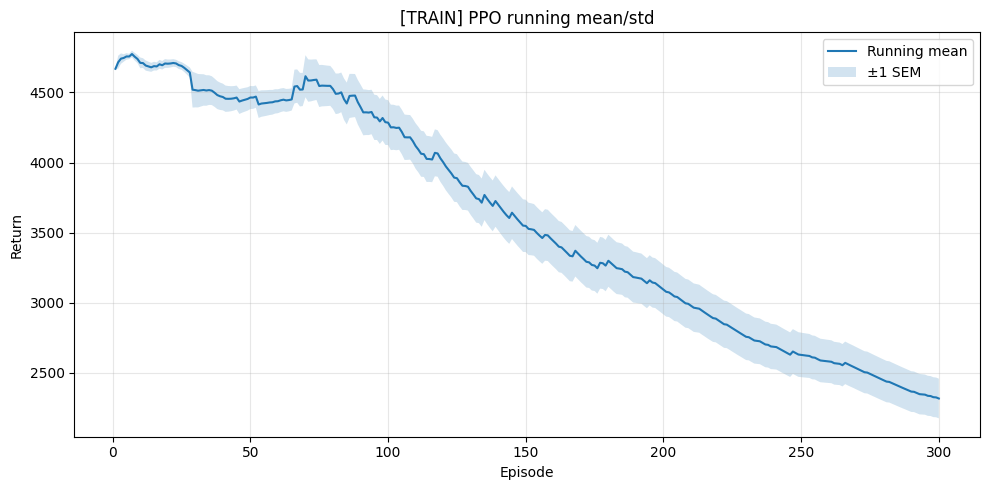

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


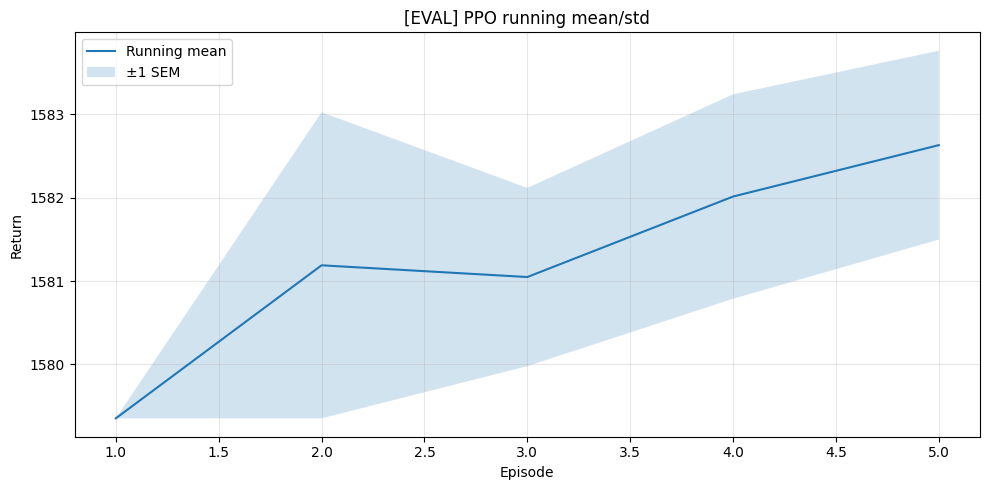

In [ ]:
def plot_running_stats(returns, title: str):
    r = np.asarray(returns, dtype=np.float64)
    if r.size == 0:
        print("No episodes logged yet in train.monitor.csv"); return
    N = r.size
    idx = np.arange(1, N + 1)
    run_mean = np.cumsum(r) / idx
    run_std  = np.zeros(N, dtype=np.float64)
    if N >= 2:
        for k in range(2, N + 1):
            run_std[k - 1] = r[:k].std(ddof=1)
    run_sem = np.where(idx > 1, run_std / np.sqrt(idx), 0.0)

    plt.figure(figsize=(10,5))
    plt.plot(idx, run_mean, label="Running mean")
    plt.fill_between(idx, run_mean - run_sem, run_mean + run_sem, alpha=0.2, label="±1 SEM")
    plt.xlabel("Episode"); plt.ylabel("Return"); plt.title(title); plt.grid(True, alpha=0.3); plt.legend()
    plt.tight_layout(); plt.show()

df = pd.read_csv("train.monitor.csv", comment="#")
returns = df["r"].to_numpy(dtype=np.float64)
plot_running_stats(returns, title="[TRAIN] PPO running mean/std")
df = pd.read_csv("eval.monitor.csv", comment="#")
returns = df["r"].to_numpy(dtype=np.float64)
plot_running_stats(returns, title="[EVAL] PPO running mean/std")


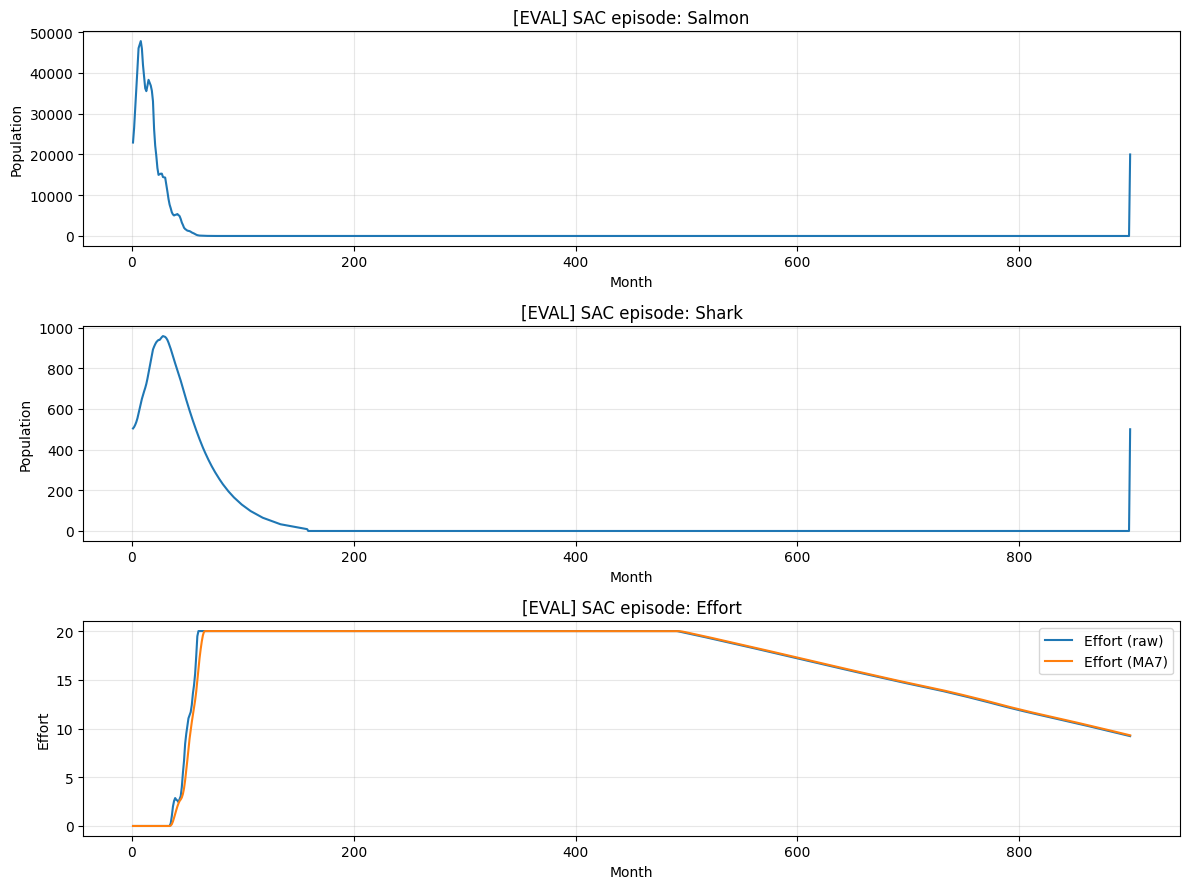

Sample episode return: -140.6728970799595
Total salmon caught: 7670.00
Total effort: 14834.29
Final populations at the end of episode -> Salmon: 20000.00, Shark: 500.00


In [ ]:
# single-episode trajectories
def rollout_one_episode_and_plot(model, env, smooth_effort_window=7, title_prefix="[EVAL] PPO episode"):
    def unwrap_env(vec_env):
        # VecEnv -> first sub-env, then unwrap Monitor -> base env
        base = vec_env.envs[0] if hasattr(vec_env, "envs") else vec_env
        while hasattr(base, "env"):
            base = base.env
        return base

    # CHANGE: VecEnv.reset() returns obs only (no info)
    obs = env.reset()
    done = False

    # use full-step index 1..horizon for x-axis (not month % 12)
    t_idx, salmon_hist, shark_hist, effort_hist, reward_hist = [], [], [], [], []

    total_salmon_caught = 0.0
    total_effort = 0.0

    while not done:
        base_env = unwrap_env(env)
        t_idx.append(len(t_idx) + 1)  # 1..900

        # deterministic policy for evaluation
        action, _ = model.predict(obs, deterministic=True)

        # CHANGE: VecEnv step signature is (obs, rewards, dones, infos)
        obs2, reward, done, infos = env.step(action)

        # coerce VecEnv returns to scalars
        if isinstance(done, (np.ndarray, list)):
            done = bool(done[0])
        info = infos[0] if isinstance(infos, (list, tuple)) and len(infos) > 0 else {}
        reward = float(np.array(reward).reshape(-1)[0])

        # pull states/effort (we exposed them in OceanEnv.step info)
        effort = float(info.get("effort", float(np.array(action).reshape(-1)[0])))
        catch = float(info.get("salmon_caught", 0.0))
        s = float(getattr(base_env, "salmon", float("nan")))
        k = float(getattr(base_env, "shark", float("nan")))

        effort_hist.append(effort)
        salmon_hist.append(s)
        shark_hist.append(k)
        reward_hist.append(reward)
        total_effort += effort
        total_salmon_caught += catch
        obs = obs2

    final_env = unwrap_env(env)
    final_salmon = float(getattr(final_env, "salmon", float("nan")))
    final_shark  = float(getattr(final_env, "shark",  float("nan")))

    # moving average for effort (same shape as effort_hist)
    def _moving_avg(x, k):
        if k <= 1 or len(x) < 2:
            return np.asarray(x, dtype=float)
        x = np.asarray(x, dtype=float)
        k = min(k, len(x))
        c = np.cumsum(np.insert(x, 0, 0.0))
        ma = (c[k:] - c[:-k]) / float(k)
        pad_left = np.full(k - 1, ma[0], dtype=float)
        return np.concatenate([pad_left, ma])

    effort_smooth = _moving_avg(effort_hist, smooth_effort_window)

    # --- three-panel plot: Salmon, Shark, Effort(+MA) over 1..900 months ---
    nrows = 3
    plt.figure(figsize=(12, 9))

    ax1 = plt.subplot(nrows, 1, 1)
    ax1.plot(t_idx, salmon_hist)
    ax1.set_title(f"{title_prefix}: Salmon")
    ax1.set_xlabel("Month")
    ax1.set_ylabel("Population")
    ax1.grid(True, alpha=0.3)

    ax2 = plt.subplot(nrows, 1, 2, sharex=ax1)
    ax2.plot(t_idx, shark_hist)
    ax2.set_title(f"{title_prefix}: Shark")
    ax2.set_xlabel("Month")
    ax2.set_ylabel("Population")
    ax2.grid(True, alpha=0.3)

    ax3 = plt.subplot(nrows, 1, 3, sharex=ax1)
    ax3.plot(t_idx, effort_hist, label="Effort (raw)")
    if len(effort_hist) >= 2:
        ax3.plot(t_idx, effort_smooth, label=f"Effort (MA{min(smooth_effort_window, len(effort_hist))})")
    ax3.set_title(f"{title_prefix}: Effort")
    ax3.set_xlabel("Month")
    ax3.set_ylabel("Effort")
    ax3.grid(True, alpha=0.3)
    ax3.legend()

    plt.tight_layout()
    plt.show()

    return {
        "months": t_idx,
        "salmon": salmon_hist if salmon_hist else None,
        "shark": shark_hist if shark_hist else None,
        "effort": effort_hist,
        "effort_smooth": effort_smooth,
        "ep_return": float(np.sum(reward_hist)),
        "total_caught": float(total_salmon_caught),
        "total_effort": float(total_effort),
        "final_salmon": final_salmon,
        "final_shark": final_shark,
    }
# Run once to reproduce the SAC-style single-episode figure
traj = rollout_one_episode_and_plot(model, eval_env, smooth_effort_window=7, title_prefix="[EVAL] SAC episode")
print("Sample episode return:", traj["ep_return"])
print(f"Total salmon caught: {traj['total_caught']:.2f}")
print(f"Total effort: {traj['total_effort']:.2f}")
print(f"Final populations at the end of episode -> Salmon: {traj['final_salmon']:.2f}, Shark: {traj['final_shark']:.2f}")


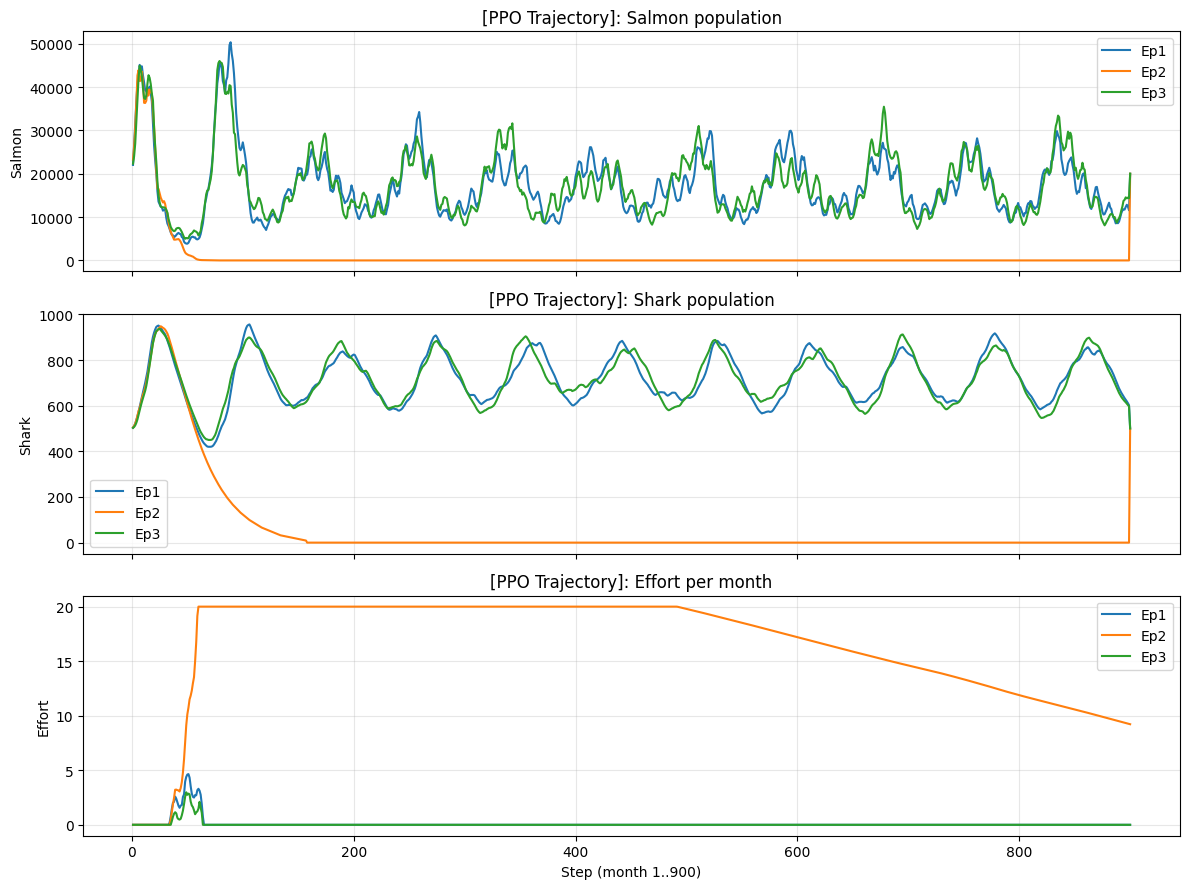

In [ ]:
def eval_and_plot_full_trajectories(model, env, episodes=3, title_prefix="[PPO Trajectory]"):
    def unwrap_env(vec_env):
        # VecEnv -> first sub-env, then unwrap Monitor -> base env
        base = vec_env.envs[0] if hasattr(vec_env, "envs") else vec_env
        while hasattr(base, "env"):
            base = base.env
        return base

    fig, axes = plt.subplots(3, 1, figsize=(12, 9), sharex=True)

    for ep in range(episodes):
        # VecEnv.reset() -> obs only
        obs = env.reset()
        done = False

        # step-index for 1..horizon so we see the full 900-month trajectory
        t_idx, s_hist, k_hist, e_hist = [], [], [], []

        while not done:
            base_env = unwrap_env(env)

            # keep full-step index (1..horizon), not month mod 12
            t_idx.append(len(t_idx) + 1)

            # deterministic eval policy
            action, _ = model.predict(obs, deterministic=True)

            # VecEnv step: (obs, rewards, dones, infos)
            obs2, reward, done, infos = env.step(action)

            # coerce list/array returns from VecEnv
            if isinstance(done, (np.ndarray, list)):
                done = bool(done[0])
            info = infos[0] if isinstance(infos, (list, tuple)) and len(infos) > 0 else {}

            # pull logged state/effort; fall back to action if info missing
            effort = float(info.get("effort", float(np.array(action).reshape(-1)[0])))
            s = float(getattr(base_env, "salmon", float("nan")))
            k = float(getattr(base_env, "shark", float("nan")))

            e_hist.append(effort)
            s_hist.append(s)
            k_hist.append(k)
            obs = obs2

        axes[0].plot(t_idx, s_hist, label=f"Ep{ep+1}")
        axes[1].plot(t_idx, k_hist, label=f"Ep{ep+1}")
        axes[2].plot(t_idx, e_hist, label=f"Ep{ep+1}")

    axes[0].set_title(f"{title_prefix}: Salmon population")
    axes[1].set_title(f"{title_prefix}: Shark population")
    axes[2].set_title(f"{title_prefix}: Effort per month")

    axes[2].set_xlabel("Step (month 1..900)")
    axes[0].set_ylabel("Salmon")
    axes[1].set_ylabel("Shark")
    axes[2].set_ylabel("Effort")

    for ax in axes:
        ax.grid(True, alpha=0.3)
        ax.legend()

    plt.tight_layout()
    plt.show()
eval_and_plot_full_trajectories(model, eval_env, episodes=3, title_prefix="[PPO Trajectory]")


In [ ]:
def summarize_at_75y(model, env):
    """Runs 1 deterministic eval episode (900 months) and prints totals and terminal populations."""
    # VecEnv reset returns obs (no info)
    obs = env.reset()
    done = False
    last_info = {}

    def unwrap_env(vec_env):
        base = vec_env.envs[0] if hasattr(vec_env, "envs") else vec_env
        while hasattr(base, "env"): base = base.env
        return base

    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, infos = env.step(action)
        # VecEnv gives list of infos; keep the latest
        last_info = infos[0] if isinstance(infos, (list, tuple)) and len(infos) else {}
        if isinstance(done, (list, np.ndarray)): done = bool(done[0])

    # Prefer reading directly from the underlying env to avoid any last-step edge cases
    base_env = unwrap_env(env)
    out = {
        "years": 75,
        "months": 900,
        "total_salmon_caught": float(getattr(base_env, "total_salmon_caught", last_info.get("total_salmon_caught", np.nan))),
        "total_effort": float(getattr(base_env, "total_effort", last_info.get("total_effort", np.nan))),
        "salmon_T": float(getattr(base_env, "salmon", last_info.get("salmon", np.nan))),
        "shark_T":  float(getattr(base_env, "shark", last_info.get("shark", np.nan))),
    }
    print(
        f"[75y Summary] total_salmon_caught={out['total_salmon_caught']:.2f}  |  "
        f"total_effort={out['total_effort']:.2f}  |  "
        f"salmon_T={out['salmon_T']:.2f}  |  shark_T={out['shark_T']:.2f}"
    )
    return out

# Run once on your trained model:
summary_75y = summarize_at_75y(model, eval_env)


[75y Summary] total_salmon_caught=0.00  |  total_effort=0.00  |  salmon_T=20000.00  |  shark_T=500.00


In [ ]:
def summarize_at_75y(model, env):
    """Runs 1 deterministic eval episode (900 months) and prints totals and terminal populations."""
    # VecEnv reset returns obs (no info)
    obs = env.reset()
    done = False
    last_info = {}

    def unwrap_env(vec_env):
        base = vec_env.envs[0] if hasattr(vec_env, "envs") else vec_env
        while hasattr(base, "env"): base = base.env
        return base

    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, infos = env.step(action)
        # VecEnv gives list of infos; keep the latest
        last_info = infos[0] if isinstance(infos, (list, tuple)) and len(infos) else {}
        if isinstance(done, (list, np.ndarray)): done = bool(done[0])

    # Prefer reading directly from the underlying env to avoid any last-step edge cases
    base_env = unwrap_env(env)
    out = {
        "years": 75,
        "months": 900,
        "total_salmon_caught": float(getattr(base_env, "total_salmon_caught", last_info.get("total_salmon_caught", np.nan))),
        "total_effort": float(getattr(base_env, "total_effort", last_info.get("total_effort", np.nan))),
        "salmon_T": float(getattr(base_env, "salmon", last_info.get("salmon", np.nan))),
        "shark_T":  float(getattr(base_env, "shark", last_info.get("shark", np.nan))),
    }
    print(
        f"[75y Summary] total_salmon_caught={out['total_salmon_caught']:.2f}  |  "
        f"total_effort={out['total_effort']:.2f}  |  "
        f"salmon_T={out['salmon_T']:.2f}  |  shark_T={out['shark_T']:.2f}"
    )
    return out

# Run once on your trained model:
summary_75y = summarize_at_75y(model, eval_env)


[75y Summary] total_salmon_caught=0.00  |  total_effort=0.00  |  salmon_T=20000.00  |  shark_T=500.00
